In this notebook, we explored automatic model selection using TPOT. If you plan to use TPOT in the future, I strongly suggest you look at its excellent [documentation](http://epistasislab.github.io/tpot/).

#Install tpot

In [ ]:
pip install tpot

1) **Importing Libraries**

In [ ]:
# Importing necessary libraries 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from tpot import TPOTClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score

#Importing library for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
#Filter the unwanted warning
import warnings
warnings.simplefilter("ignore")

2) **Loading the blood donations data**

We now know that we are working with a typical CSV file (i.e., the delimiter is ,, etc.). We proceed to loading the data into memory.

In [ ]:
#Lets get started exploring the data.

train = pd.read_csv("/content/blood-train.csv")
test=pd.read_csv("/content/blood-test.csv")
train.head()

,Unnamed: 0,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation,Made Donation in March 2007
0,619,2,50,12500,98,1
1,664,0,13,3250,28,1
2,441,1,16,4000,35,1
3,160,2,20,5000,45,1
4,358,1,24,6000,77,0


3) **Inspecting transfusion DataFrame**

The RFM model stands for Recency, Frequency and Monetary Value and it is commonly used in marketing for identifying the best customers. In this case, the customers are blood donors.

RFMTC is a variation of the RFM model. Below is a description of what each column means in the dataset:

R (Recency - months since the last donation)
F (Frequency - total number of donation)
M (Monetary - total volume blood donated in c.c.)
T (Time - months since the first donation)
a binary variable representing whether he/she donated blood in March 2007 (1 stands for donating blood; 0 stands for not donating blood)
It will be helpful to rename these columns as such; except for the last column, which will be the Target column, as the aim is to predict whether someone donated blood in March 2007.

In [ ]:
#Printing the train and test size
print("Train Shape : ",train.shape)
print("Test Shape : ",test.shape)

Train Shape :  (576, 6)
Test Shape :  (200, 5)


NOTE:

> We can see that there are 576 rows and 6 columns in our training dataset

> We can see that there are 200 rows and 5 columns in our test dataset

In [ ]:
# Print a concise summary of transfusion DataFrame
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576 entries, 0 to 575
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   Unnamed: 0                   576 non-null    int64
 1   Months since Last Donation   576 non-null    int64
 2   Number of Donations          576 non-null    int64
 3   Total Volume Donated (c.c.)  576 non-null    int64
 4   Months since First Donation  576 non-null    int64
 5   Made Donation in March 2007  576 non-null    int64
dtypes: int64(6)
memory usage: 27.1 KB


NOTE:

> We can see that there is no missing vale for any row.

> The datatype for all features is integer.

4. **Creating target column**

We are aiming to predict the value in whether he/she donated blood in March 2007 column. Let's rename this it to target so that it's more convenient to work with

In [ ]:
# Rename target column as 'target' for brevity
train.rename(
    columns={'Made Donation in March 2007':'Target'},
    inplace=True
)   

5.**Checking target incidence**

We want to predict whether or not the same donor will give blood the next time the vehicle comes to campus. The model for this is a binary classifier, meaning that there are only 2 possible outcomes:

0 - the donor will not give blood
1 - the donor will give blood
Target incidence is defined as the number of cases of each individual target value in a dataset. That is, how many 0s in the target column compared to how many 1s? Target incidence gives us an idea of how balanced (or imbalanced) is our dataset.

In [ ]:
#Counting the number of people who donated and not donated
train["Target"].value_counts()

0    438
1    138
Name: Target, dtype: int64

Note:
> This is an imbalance dataset.

6) **Looking into the testing dataset**

In [ ]:
test.head()

,Unnamed: 0,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation
0,659,2,12,3000,52
1,276,21,7,1750,38
2,263,4,1,250,4
3,303,11,11,2750,38
4,83,4,12,3000,34


Note:
> Made Donation in March 2007 is not present in Test data.

> We have to train our classifier using the Train data and generate predictions (Made Donation in March 2007) on Test data.

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   Unnamed: 0                   200 non-null    int64
 1   Months since Last Donation   200 non-null    int64
 2   Number of Donations          200 non-null    int64
 3   Total Volume Donated (c.c.)  200 non-null    int64
 4   Months since First Donation  200 non-null    int64
dtypes: int64(5)
memory usage: 7.9 KB


NOTE:

> We can see that there is no missing vale for any row.
> 
> The datatype for all features is an integer.

# **Data Exploration**


7) **Describing training dataset**

describe() method can show different values like count, mean, standard deviation, etc. of numeric data types.

In [ ]:
# Statistics of the data
train.describe()

,Unnamed: 0,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation,Target
count,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000
mean,374.034722,9.439236,5.427083,1356.770833,34.050347,0.239583
std,216.947773,8.175454,5.740010,1435.002556,24.227672,0.427200
min,0.000000,0.000000,1.000000,250.000000,2.000000,0.000000
25%,183.750000,2.000000,2.000000,500.000000,16.000000,0.000000
50%,375.500000,7.000000,4.000000,1000.000000,28.000000,0.000000
75%,562.500000,14.000000,7.000000,1750.000000,49.250000,0.000000
max,747.000000,74.000000,50.000000,12500.000000,98.000000,1.000000


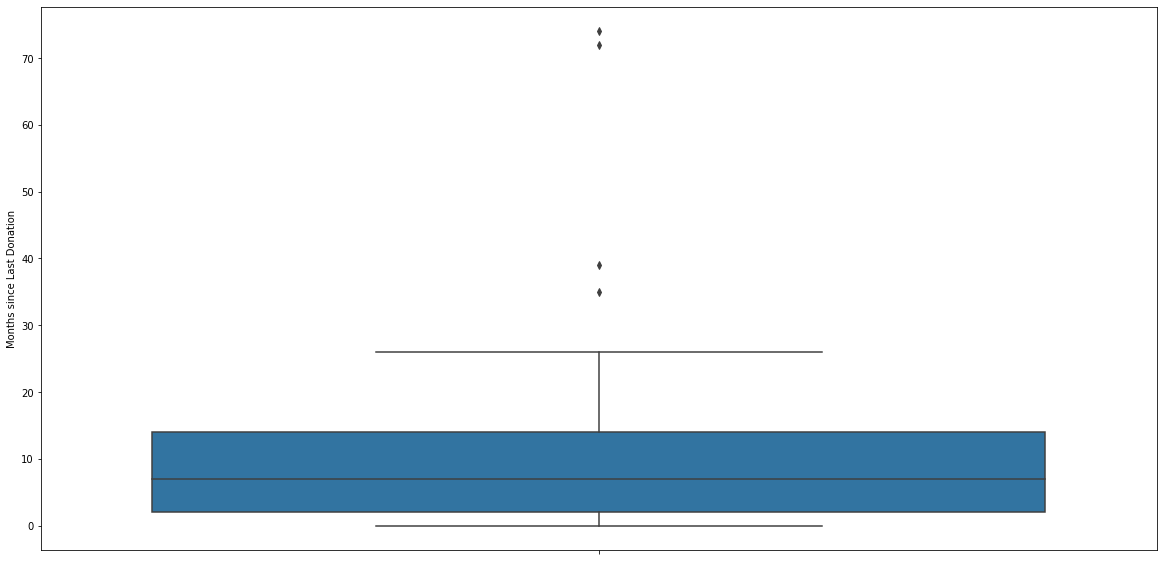

In [ ]:
#Boxplot for Months since Last Donation
plt.figure(figsize=(20,10)) 
sns.boxplot(y="Months since Last Donation",data=train)

Note:
> We can see that most of donations happened around 10th month
> There are some outliers

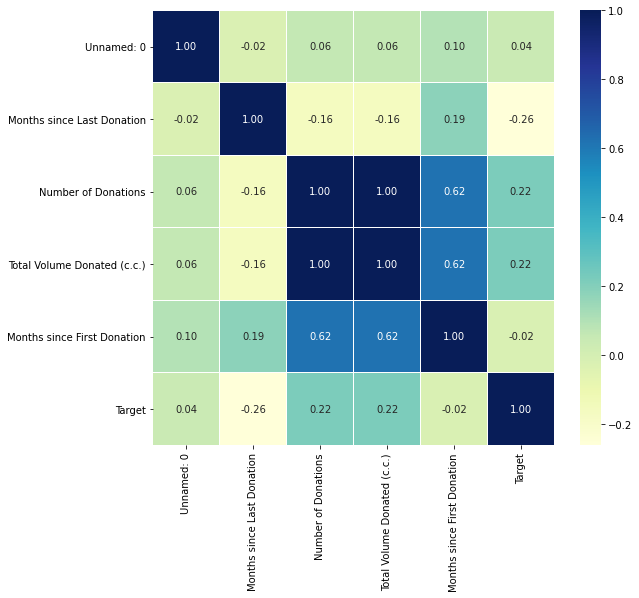

In [ ]:
#Correlation between all variables [Checking how different variable are related]
corrmat=train.corr()
f, ax = plt.subplots(figsize =(9, 8)) 
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1,fmt = ".2f",annot=True)

NOTE:
Heatmap of Correlation between different features:

Positive numbers = Positive correlation, i.e. increase in one feature will increase the other feature & vice-versa.
Negative numbers = Negative correlation, i.e. increase in one feature will decrease the other feature & vice-versa.

In our case, we focus on which features have strong positive or negative correlation with the Target feature.

# **Model Building**

9. **Splitting dataset into train and test datasets**

We'll now use train_test_split() method to split DataFrame.This is very easy to do using the train_test_split() method from the scikit learn library - all we need to do is specify the stratify parameter. In our case, we'll stratify on the target column.

In [ ]:
# Import train_test_split method
from sklearn.model_selection import train_test_split

# Split transfusion DataFrame into
# X_train, X_test, y_train and y_test datasets,
# stratifying on the `target` column
X_train, X_test, y_train, y_test = train_test_split(
    train.drop(columns=['Target','Unnamed: 0']),
    train.Target,
    test_size=0.2,
    random_state=0)

10. **Selecting model using TPOT**

TPOT is a Python Automated Machine Learning tool that optimizes machine learning pipelines using genetic programming.
![download.png](attachment:download.png)

TPOT will automatically explore hundreds of possible pipelines to find the best one for our dataset. Note, the outcome of this search will be a scikit-learn pipeline, meaning it will include any pre-processing steps as well as the model.

We are using TPOT to help us zero in on one model that we can then explore and optimize further.

In [ ]:
# Import TPOTClassifier and roc_auc_score
from tpot import TPOTClassifier
from sklearn.metrics import roc_auc_score

# Instantiate TPOTClassifier
tpot = TPOTClassifier(
    generations=5,
    population_size=20,
    verbosity=2,
    scoring='roc_auc',
    random_state=42,
    disable_update_check=True,
    config_dict='TPOT light'
)
tpot.fit(X_train, y_train)

# AUC score for tpot model
tpot_auc_score = roc_auc_score(y_test, tpot.predict_proba(X_test)[:, 1])
print(f'\nAUC score: {tpot_auc_score:.4f}')


# Print best pipeline steps
print('\nBest pipeline steps:', end='\n')
for idx, (name, transform) in enumerate(tpot.fitted_pipeline_.steps, start=1):
    # Print idx and transform
    print(f'{idx}. {transform}')



Generation 1 - Current best internal CV score: 0.7355558350100603
Generation 2 - Current best internal CV score: 0.7355558350100603
Generation 3 - Current best internal CV score: 0.7355558350100603
Generation 4 - Current best internal CV score: 0.7355558350100603
Generation 5 - Current best internal CV score: 0.7445383411580595
Best pipeline: LogisticRegression(GaussianNB(input_matrix), C=25.0, dual=False, penalty=l2)

AUC score: 0.7647

Best pipeline steps:
1. StackingEstimator(estimator=GaussianNB(priors=None, var_smoothing=1e-09))
2. LogisticRegression(C=25.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [ ]:
tpot.fitted_pipeline_

Pipeline(memory=None,
         steps=[('stackingestimator',
                 StackingEstimator(estimator=GaussianNB(priors=None,
                                                        var_smoothing=1e-09))),
                ('logisticregression',
                 LogisticRegression(C=25.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=42,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

TPOT picked LogisticRegression as the best model for our dataset with no pre-processing , giving us the AUC score of 0.8042. This is a great starting point. Let's see if we can make it better.


10. Training the linear regression model¶

We are now ready to train the linear regression model.

In [ ]:
# Importing modules
from sklearn.linear_model import LogisticRegression
# Instantiate LogisticRegression
logreg = LogisticRegression(C=25.0, random_state=42)
#Fitting the model
logreg.fit(X_train,y_train)

LogisticRegression(C=25.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
#Predicting on the test data
pred=logreg.predict(X_test)

In [ ]:
#printing the confusion matrix
confusion_matrix(pred,y_test)

array([[80, 29],
       [ 1,  6]])

In [ ]:
# AUC score for tpot model
logreg_auc_score = roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1])
print(f'\nAUC score: {logreg_auc_score:.4f}')


AUC score: 0.8042


11. **Conclusion**

In this notebook, we explored automatic model selection using TPOT and AUC score we got was 0.8042. This is better than simply choosing 0 all the time (the target incidence suggests that such a model would have 76% success rate). If you plan to use TPOT in the future, I strongly suggest you look at its excellent [documentation](http://epistasislab.github.io/tpot/). You can further improve the auc score by removing outliers as logistic regression is sensitive to outliers. Thus, removing outliers can further improve it.

#Limitations

1) TPOT can take a long time to finish its search
2) TPOT can recommend different solutions for the same dataset
